# Assignment 5 - Stochastic Differential Equations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

## Exercise 5.1 - Stochastic double integrator (3 points)

Create a simulation of the stochastic double integrator and visualise the evolution of the probability density of the position and velocity of the particle.

In [17]:
x_init = np.zeros(2)

gamma = 0.4
omega = 0.01

def f(x1, x2, dt, t):
    system = dt * np.array([x2, -gamma * x2])
    noise = np.random.normal(0, dt) * np.array([0, omega])
    return system + noise

In [18]:
np.random.seed(0)

interval = 10
dt = 0.01

chains = 100

ts = np.arange(0, interval, dt)
xss = [[x_init] for _ in range(chains)]

for t in ts[1:]:
    for i in range(chains):
        xss[i].append(xss[i][-1] + f(*xss[i][-1], dt, t))

/home/borroot/Sync/courses/virtualenv-courses/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/borroot/Sync/courses/virtualenv-courses/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


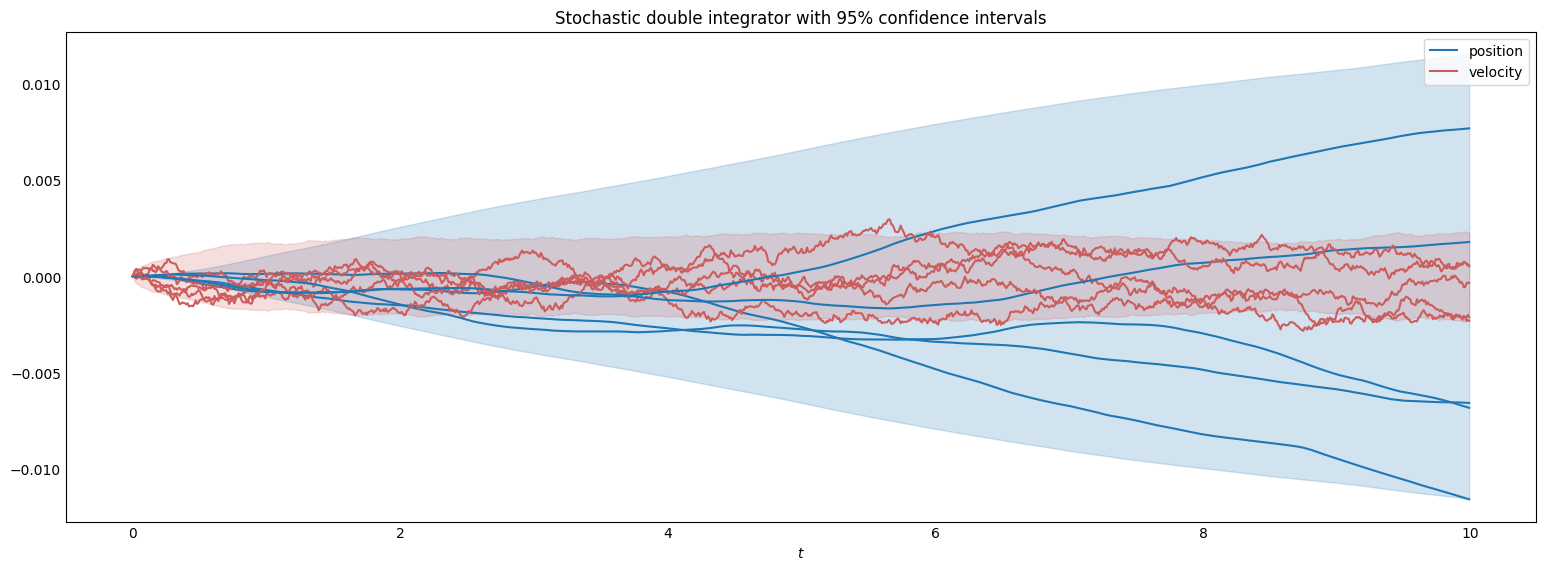

In [19]:
plt.figure(figsize=(15, 5))

xss = np.array(xss)
colors = ['tab:blue', 'indianred']

# plot some trajectories
for i in range(min(5, chains)):
    for x in range(2):
        plt.plot(ts, xss[i, :, x], color=colors[x])

# note that standard error of the mean (sem) = standard error * sqrt(number of samples/chains)
# compute the confidence interval
std_error = st.sem(xss, axis=(0)) * np.sqrt(chains)
confidence = np.array(st.t.interval(0.95, len(ts), loc=0, scale=std_error))

# plot the confidence interval
for x in range(2):
    plt.fill_between(ts, *confidence[:, :, x], color=colors[x], alpha=0.2)

# final plotting
plt.xlabel(r"$t$")

plt.legend(['position', 'velocity'])
plt.title('Stochastic double integrator with 95% confidence intervals')

plt.savefig('images/double-integrator.png')
plt.show()

## Exercise 5.2 - Controlled stochastic Lotka-Volterra (4 points)
### Part 1: 
Create a stochastic Lotka-Volterra system that is solved using the Euler-Maruyama method (Eq. 2.9 and 2.10 in the lecture notes). For the parameters, you can use: 
$ \alpha = 1.1, \beta = 0.4, \gamma = 0.1, \gamma =0.4$ with an initial condition of $\mathbf{x}_0 = (10,10)^\top$. 

For the Brownian motion, you can use $\sigma = 0.05$. Make sure that your step size is small enough, and the duration of the system is sufficiently long for showing the long term evolution of the system. Show some sampled trajectories of the uncontrolled system over time as well as the phase plane, in similar to figure 2.10 in the lecture notes.

In [5]:
x_init = np.ones(2) * 10

alpha = 1.1    # growth rate prey
beta = 0.4     # death rate prey
delta = 0.1    # growth rate predator
gamma = 0.4    # death rate predator

sigma = 0.05

def f(x0, x1, dt, t=0, noisy=True):
    system = dt * np.array([alpha * x0 - beta * x0 * x1, delta * x0 * x1 - gamma * x1])
    if not noisy: return system
    noise = np.random.normal(0, np.sqrt(dt)) * np.array([sigma, sigma])
    return system + noise

In [6]:
np.random.seed(0)

interval = 50
dt = 0.001

chains = 5

ts = np.arange(0, interval, dt)
xss = [[x_init] for _ in range(chains)]

for t in ts[1:]:
    for i in range(chains):
        xss[i].append(np.clip(xss[i][-1] + f(*xss[i][-1], dt, t), 0, None))

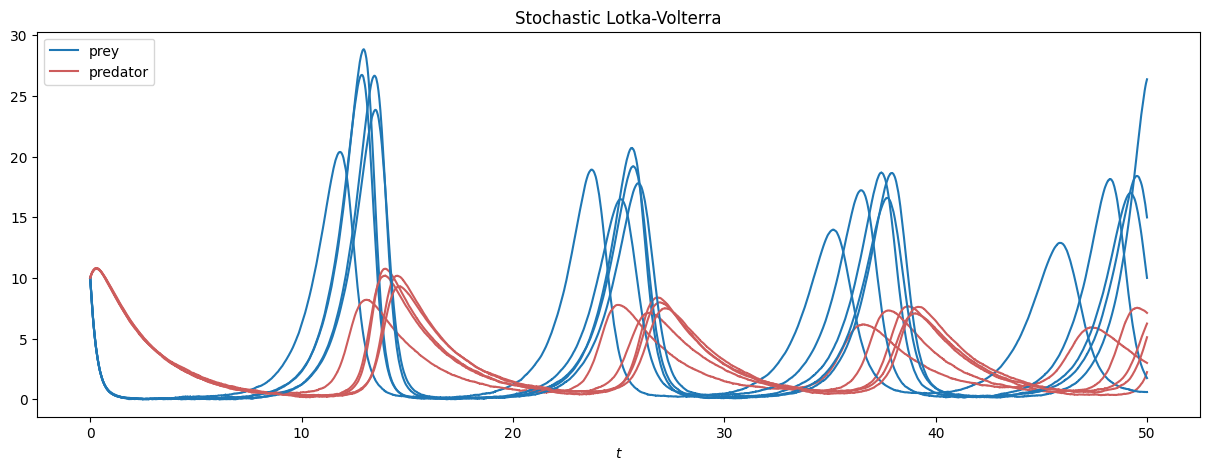

<Figure size 640x480 with 0 Axes>

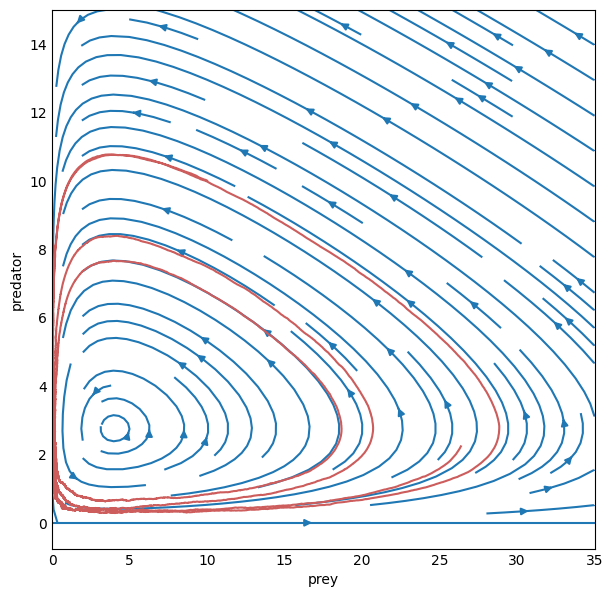

<Figure size 200x200 with 0 Axes>

In [7]:
plt.figure(figsize=(15,5))

xss = np.array(xss)

# plot some trajectories
for i in range(min(5, chains)):
    plt.plot(ts, xss[i, :, 0], color='tab:blue')
    plt.plot(ts, xss[i, :, 1], color='indianred')

plt.xlabel(r"$t$")
plt.legend(['prey', 'predator'])
plt.title('Stochastic Lotka-Volterra')

plt.savefig('images/lotka-volterra-1.png')
plt.show()

# ----------------------------------------------

plt.figure(figsize=(7, 7))
plt.style.use('_mpl-gallery-nogrid')

X0 = np.linspace(0, 35, 1000)
X1 = np.linspace(0, 15, 1000)

dX = np.array([[f(x0, x1, 0.0001, noisy=False) for x0 in X0] for x1 in X1])
plt.streamplot(X0, X1, dX[:, :, 0], dX[:, :, 1])

plt.plot(xss[0, :, 0], xss[0, :, 1], color='indianred')

plt.xlabel('prey')
plt.ylabel('predator')

plt.savefig('images/lotka-volterra-2.png')
plt.show()

### Part 2:
Create a control function $u(x)$ that receives the current state as input and returns an action as output. You have to define and find this control function yourself in such a way that the system becomes stabilized at the fixed point $\mathbf{x}^*_{\text{equilibrium}} = (\gamma / \delta , \alpha / \beta )^\top$. You are allowed to use this goal state in your definition of the control function. At no point should either predator or prey die out (i.e. have a value of 0 or a ngeative value).

For the result, show both the system evolution and control input over time, as well as the phase plane trajectory in a second figure. Explain your reasoning behind the design of the control function, and discuss to what extent the system can be controlled to its equilibrium point. And would this change when the control can only be applied to the predators?

The control function is designed with the goal state in mind. We simply calculate the difference between the current state and the goal state and take a small step in this direction. One could also immediately go to the goal state, but this is not realistic, the cost for this would probably be huge if even possible. The step size has a big influence on how fast the system converges to the desired equilibrium point. A smaller step size is likely less costly while a big step size is probably more costly, if we think about this system in a more realistic setting.

In our case we can actually converge to the equilibrium point, depending on the step size and $\Delta t$, however, in a realistic scenario, this is probably not plausible, as it requires high granularity control when approaching the equilibrium.

Not a lot changes when control is only applied to the predators. We update our function to only make a step towards the predator goal. The convergence is now a bit slower, but we can compensate for this by increasing the step size. The prey will follow the predators, since the prey want to move to the prey goal state if we force the predator in their goal state.

Note that in all the simulations it is incredibly difficult to keep the prey from dying out immediately because we start with a relatively high number of predators compared to the number of prey.

In [8]:
goal = np.array([gamma / delta, alpha / beta])

def u(x0, x1):
    return (goal - np.array([x0, x1])) * 0.1

def f(x0, x1, dt, t=0, noisy=True, u=u):
    system = dt * np.array([alpha * x0 - beta * x0 * x1, delta * x0 * x1 - gamma * x1])
    control = dt * u(x0, x1)
    if not noisy: return system + control
    noise = np.random.normal(0, np.sqrt(dt)) * np.array([omega, omega])
    return system + noise + control

In [9]:
np.random.seed(0)

interval = 50
dt = 0.001

ts = np.arange(0, interval, dt)
xs = [x_init]

for t in ts[1:]:
    xs.append(np.clip(xs[-1] + f(*xs[-1], dt, t), 0, None))

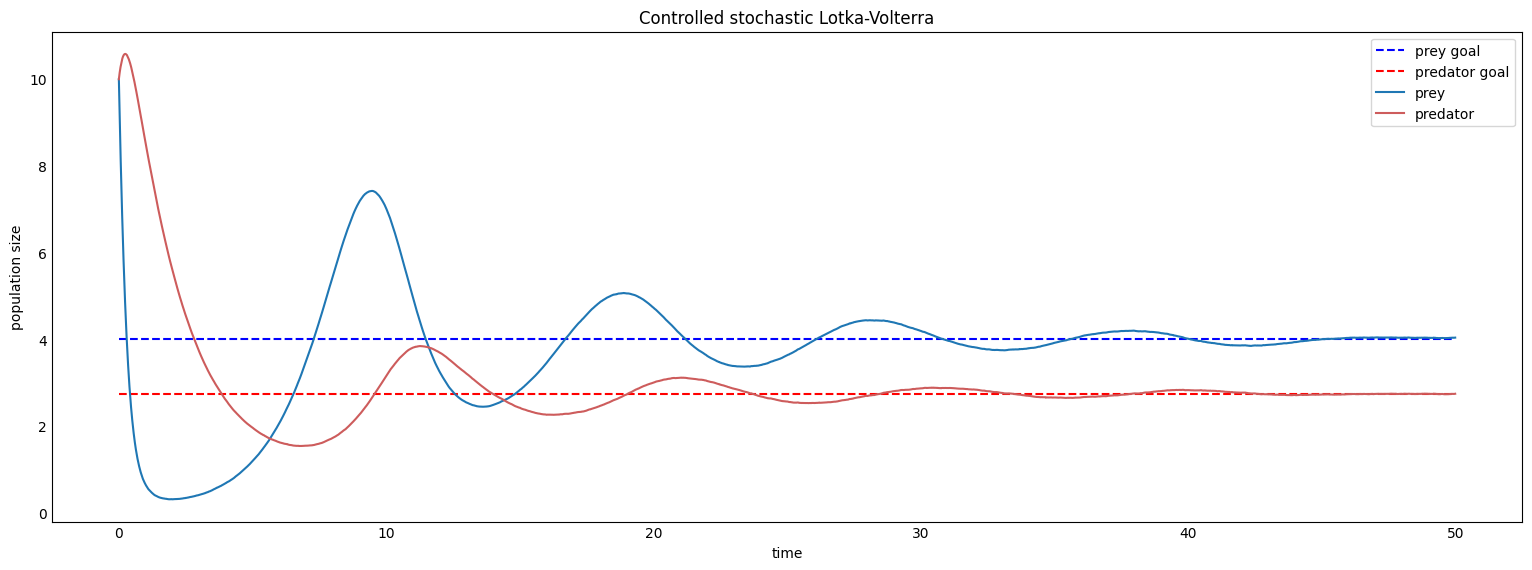

<Figure size 200x200 with 0 Axes>

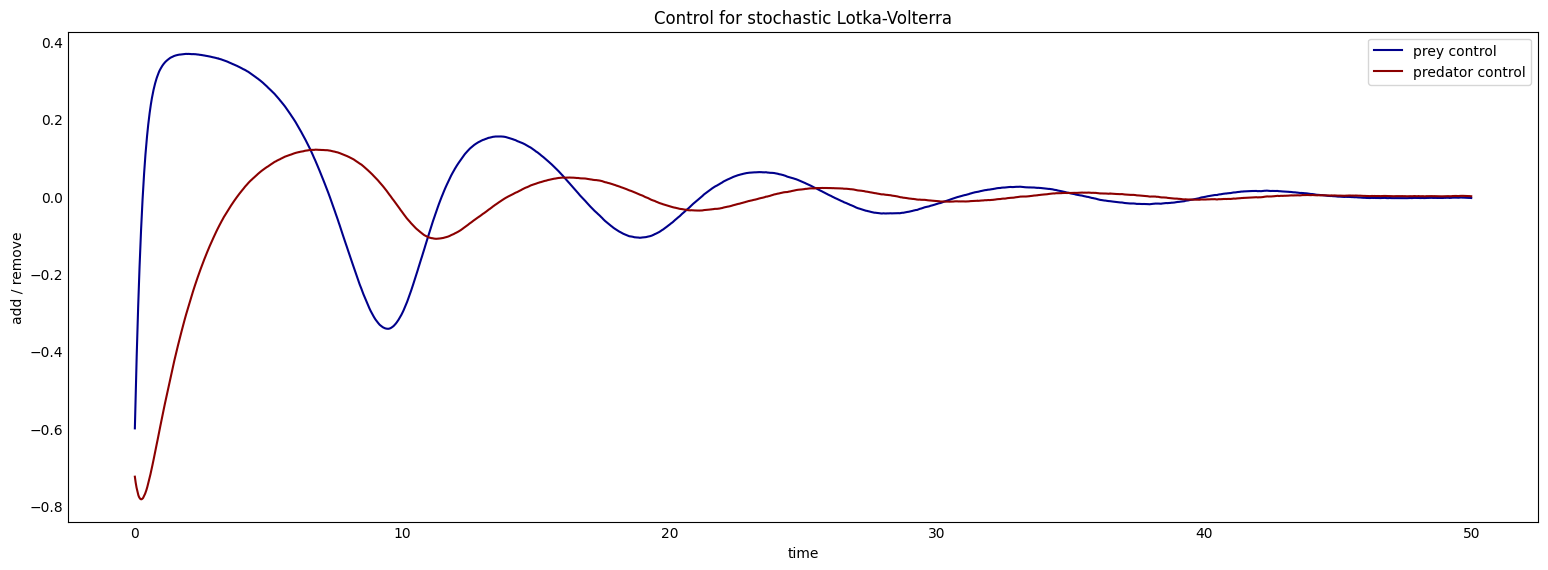

<Figure size 200x200 with 0 Axes>

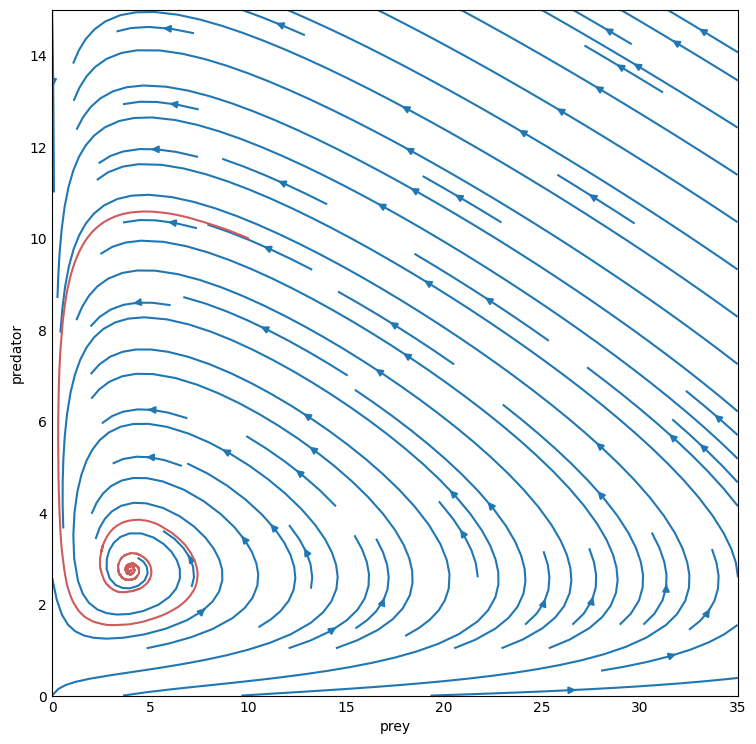

<Figure size 200x200 with 0 Axes>

In [10]:
xs = np.array(xs)

# ------------------------------------------------------

fig, ax = plt.subplots(figsize=(15,5))

ax.plot([0, interval], [goal[0]] * 2, label='prey goal', color='blue', linestyle='--')
ax.plot([0, interval], [goal[1]] * 2, label='predator goal', color='red', linestyle='--')

ax.plot(ts, xs[:, 0], label='prey', color='tab:blue')
ax.plot(ts, xs[:, 1], label='predator', color='indianred')

ax.set_ylabel('population size')
ax.set_xlabel('time')

ax.legend()
plt.title('Controlled stochastic Lotka-Volterra')

plt.savefig('images/lotka-volterra-3.png')
plt.show()

# ------------------------------------------------------

fig, ax = plt.subplots(figsize=(15,5))

control = np.array(list(map(lambda x: u(*x), xs)))

ax.plot(ts, control[:, 0], label='prey control', color='darkblue')
ax.plot(ts, control[:, 1], label='predator control', color='darkred')

ax.set_ylabel('add / remove')
ax.set_xlabel('time')

ax.legend()
plt.title('Control for stochastic Lotka-Volterra')

plt.savefig('images/lotka-volterra-4.png')
plt.show()

# ------------------------------------------------------

plt.figure(figsize=(7, 7))
plt.style.use('_mpl-gallery-nogrid')

X0 = np.linspace(0, 35, 1000)
X1 = np.linspace(0, 15, 1000)

dX = np.array([[f(x0, x1, 0.0001, noisy=False) for x0 in X0] for x1 in X1])
plt.streamplot(X0, X1, dX[:, :, 0], dX[:, :, 1])

plt.plot(xs[:, 0], xs[:, 1], color='indianred')

plt.xlabel('prey')
plt.ylabel('predator')

plt.savefig('images/lotka-volterra-5.png')
plt.show()

In [11]:
def u_predator(x0, x1):
    return np.array([0, (goal[1] - x1) * 0.3])

In [12]:
np.random.seed(0)

interval = 50
dt = 0.001

ts = np.arange(0, interval, dt)
xs = [x_init]

for t in ts[1:]:
    xs.append(np.clip(xs[-1] + f(*xs[-1], dt, t, u=u_predator), 0, None))

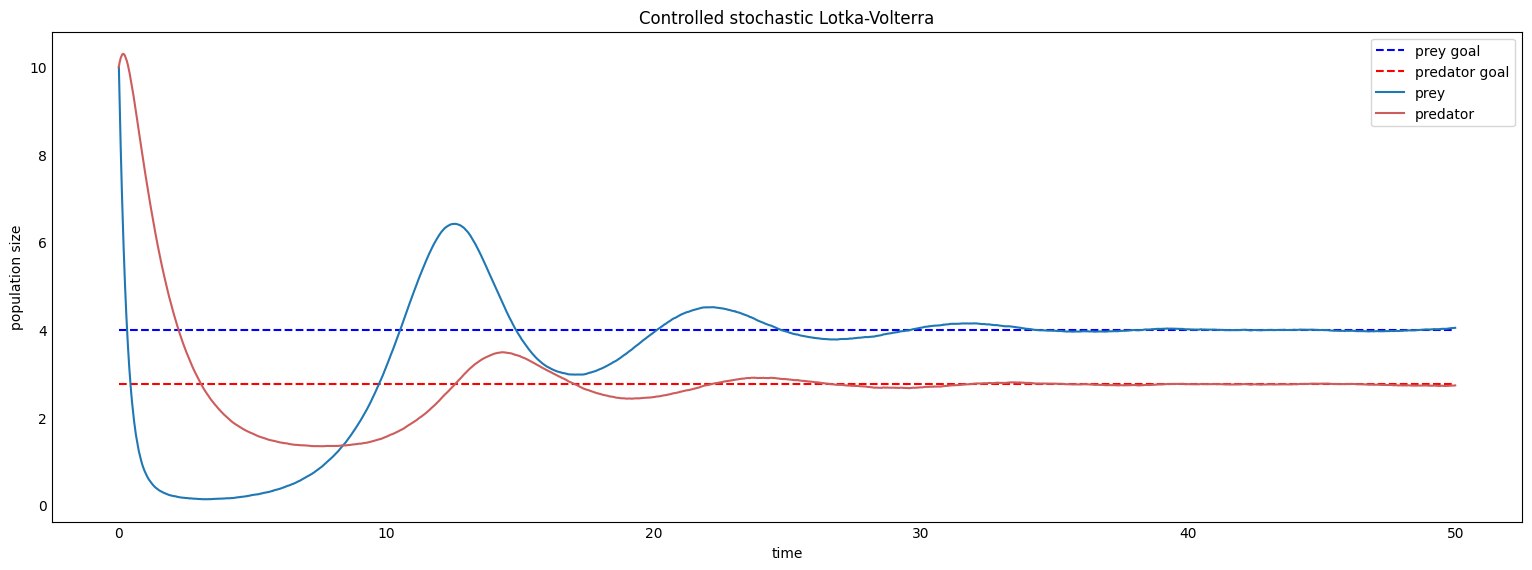

<Figure size 200x200 with 0 Axes>

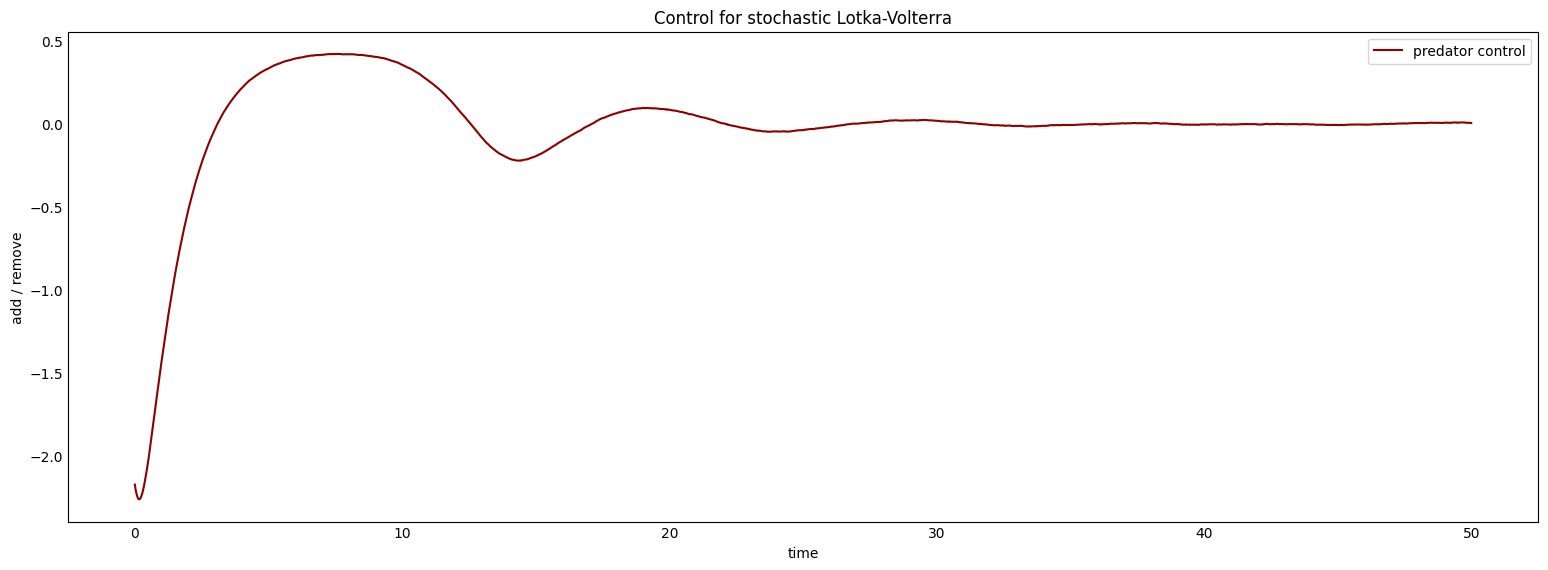

<Figure size 200x200 with 0 Axes>

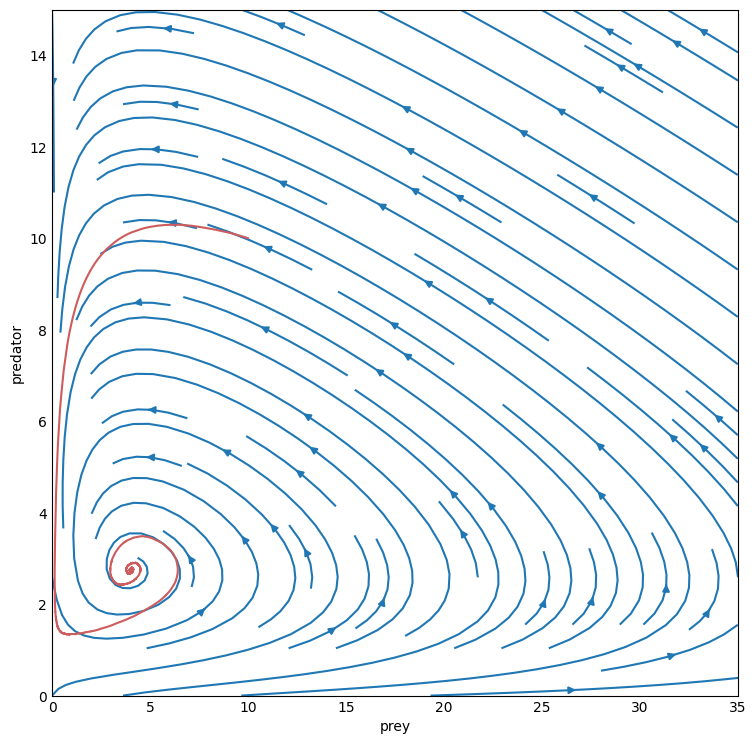

<Figure size 200x200 with 0 Axes>

In [13]:
xs = np.array(xs)

# ------------------------------------------------------

fig, ax = plt.subplots(figsize=(15,5))

ax.plot([0, interval], [goal[0]] * 2, label='prey goal', color='blue', linestyle='--')
ax.plot([0, interval], [goal[1]] * 2, label='predator goal', color='red', linestyle='--')

ax.plot(ts, xs[:, 0], label='prey', color='tab:blue')
ax.plot(ts, xs[:, 1], label='predator', color='indianred')

ax.set_ylabel('population size')
ax.set_xlabel('time')

ax.legend()
plt.title('Controlled stochastic Lotka-Volterra')

plt.savefig('images/lotka-volterra-6.png')
plt.show()

# ------------------------------------------------------

fig, ax = plt.subplots(figsize=(15,5))

control = np.array(list(map(lambda x: u_predator(*x), xs)))
ax.plot(ts, control[:, 1], label='predator control', color='darkred')

ax.set_ylabel('add / remove')
ax.set_xlabel('time')

ax.legend()
plt.title('Control for stochastic Lotka-Volterra')

plt.savefig('images/lotka-volterra-7.png')
plt.show()

# ------------------------------------------------------

plt.figure(figsize=(7, 7))
plt.style.use('_mpl-gallery-nogrid')

X0 = np.linspace(0, 35, 1000)
X1 = np.linspace(0, 15, 1000)

dX = np.array([[f(x0, x1, 0.0001, noisy=False) for x0 in X0] for x1 in X1])
plt.streamplot(X0, X1, dX[:, :, 0], dX[:, :, 1])

plt.plot(xs[:, 0], xs[:, 1], color='indianred')

plt.xlabel('prey')
plt.ylabel('predator')

plt.savefig('images/lotka-volterra-8.png')
plt.show()

## Exercise 5.3 - Coupled oscillator (3 points)

Simulate the partially observed stochastic coupled integrator.

In [14]:
k1 = 1   # spring constant oscillator 1
k2 = 10  # spring constant oscillator 2

m1 = 1   # mass osccilator 1
m2 = 1   # mass osccilator 2

kappa  = 1   # coupling spring constant
kappa1 = k1 + kappa
kappa2 = k2 + kappa

x_init = np.zeros(4)

omega = 10  # diffusion parameter for brownian noise
u = np.sin

def f(x1, x2, x3, x4, dt, t):
    system = dt * np.array([x2, -kappa1 * x1 - k2 * x3 + u(t), x4, -kappa2 * x3 - k1 * x1])
    noise = np.random.normal(0, dt) * np.array([0, 0, 0, omega])
    return system + noise

In [15]:
np.random.seed(0)

interval = 10
dt = 0.001

ts = np.arange(0, interval, dt)
xs = [x_init]

for t in ts[1:]:
    xs.append(xs[-1] + f(*xs[-1], dt, t))

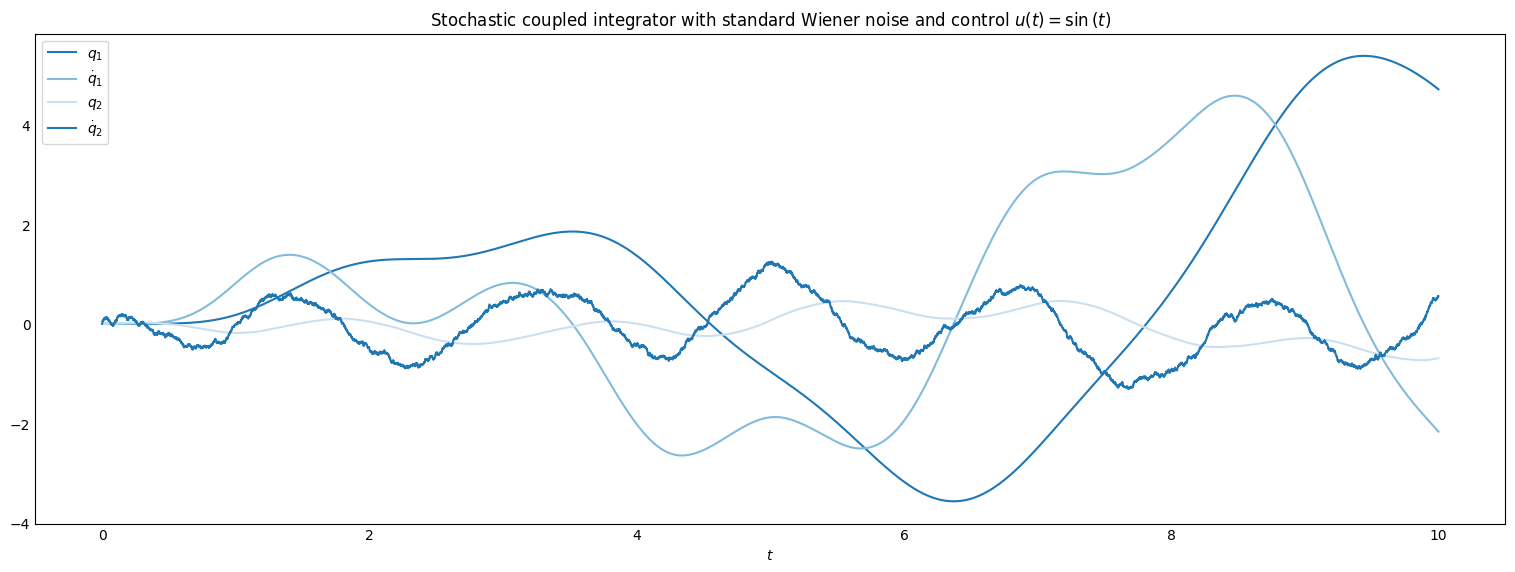

<Figure size 200x200 with 0 Axes>

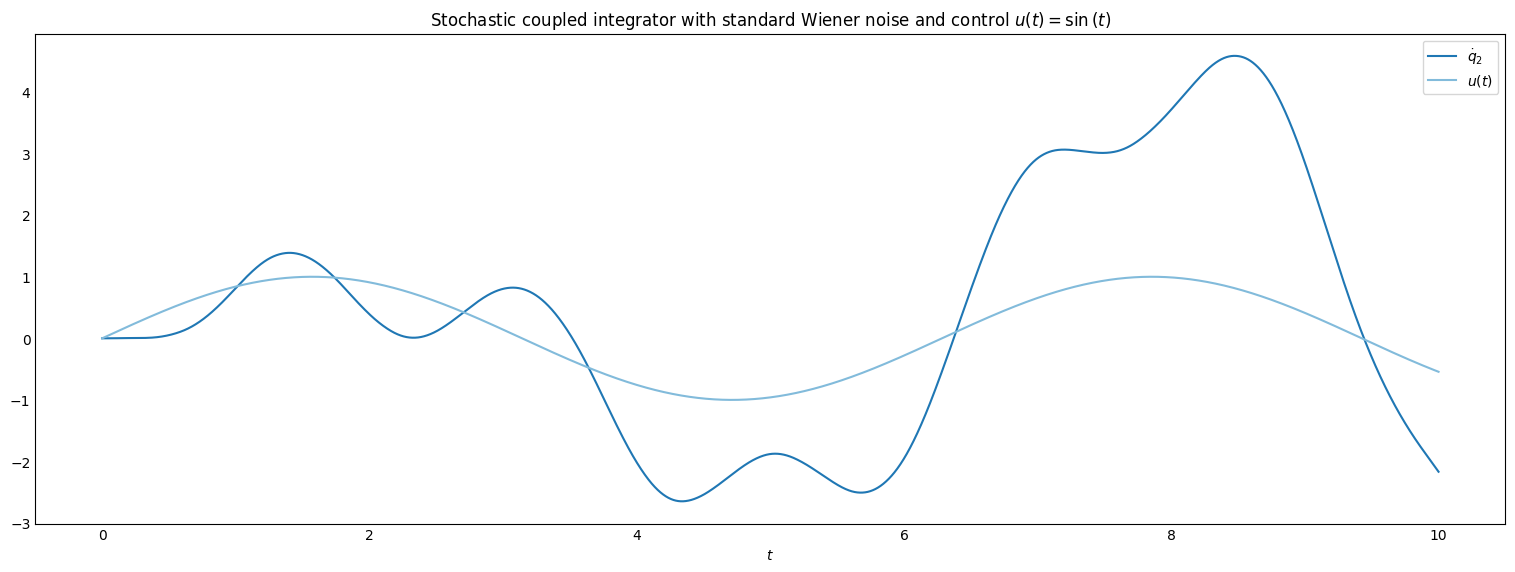

<Figure size 200x200 with 0 Axes>

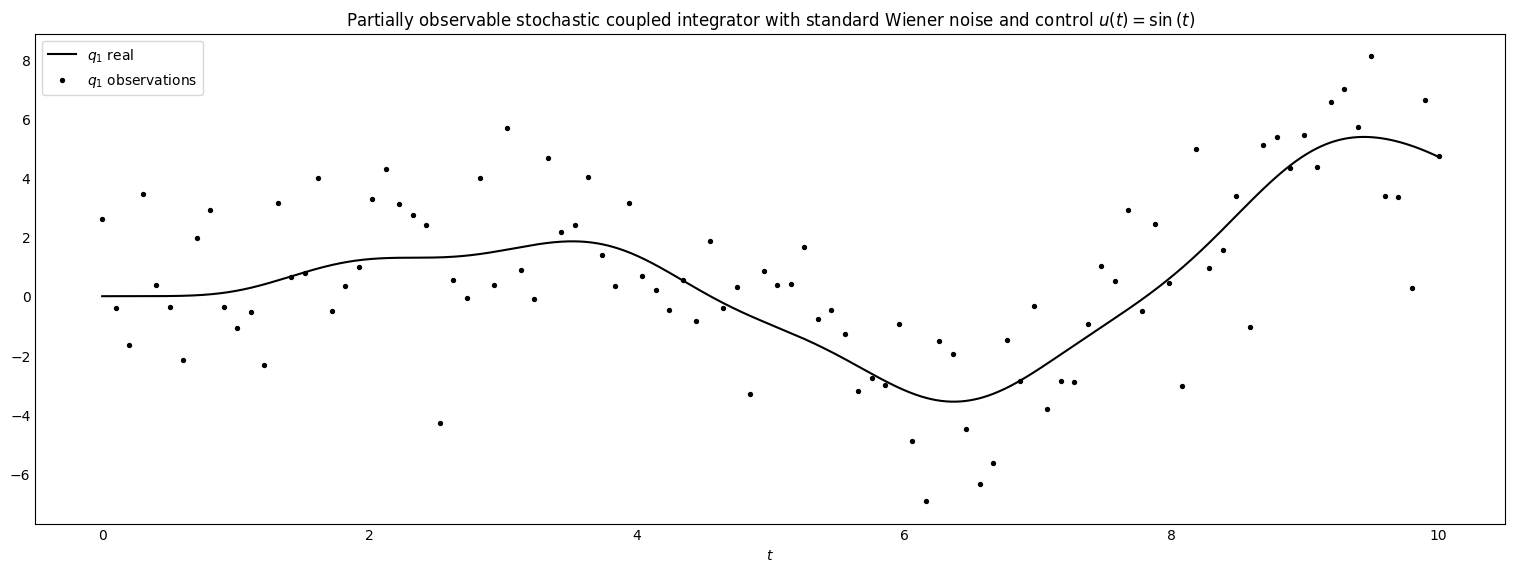

<Figure size 200x200 with 0 Axes>

In [16]:
plt.figure(figsize=(15,5))

xs = np.array(xs)
labels = ['$q_1$', '$\dot q_1$', '$q_2$', '$\dot q_2$']

for i in range(4):
    plt.plot(ts, xs[:, i], label=labels[i])

plt.legend()

plt.xlabel(r"$t$")
plt.title('Stochastic coupled integrator with standard Wiener noise and control $u(t)=\sin{(t)}$')

plt.savefig('images/double-integrator-1')
plt.show()

# ----------------------------------------------

plt.figure(figsize=(15,5))

plt.plot(ts, xs[:, 1], label='$\dot q_2$')
plt.plot(ts, list(map(u, ts)), label='$u(t)$')

plt.xlabel(r"$t$")

plt.legend()
plt.title('Stochastic coupled integrator with standard Wiener noise and control $u(t)=\sin{(t)}$')

plt.savefig('images/double-integrator-2')
plt.show()

# ----------------------------------------------

plt.figure(figsize=(15,5))

number_of_observations = 100
moments = np.arange(0, len(xs[:, 0]), len(xs[:, 0]) // number_of_observations)
observations = np.random.normal(xs[moments, 0], 2)

plt.plot(ts, xs[:, 0], label='$q_1$ real', color='black')
plt.scatter(np.linspace(0, interval, len(moments)), observations, label='$q_1$ observations', color='black', s=8)

plt.xlabel(r"$t$")

plt.legend()
plt.title('Partially observable stochastic coupled integrator with standard Wiener noise and control $u(t)=\sin{(t)}$')

plt.savefig('images/double-integrator-3')
plt.show()